In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file1='/content/drive/My Drive/MobilePriceClassification/train.csv'
data = pd.read_csv(file1)
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
data.isnull().sum() #결측치 확인

In [ ]:
#target 데이터 value 확인 :카테고리형 데이터
data['price_range'].unique()

In [ ]:
#Correlation 상관분석
corr=data.corr()
corr.sort_values(by=["price_range"],ascending=False).iloc[0].sort_values(ascending=False)
#ram, battery_power, px_width, px_height 가 top 4 features라고 볼 수 있다.

In [ ]:
#Chi-square test 카이제곱 검정
from scipy.stats import chi2_contingency

feature_chi=[]
for i in ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi']:
       chi_res  = chi2_contingency(pd.crosstab(data['price_range'], data[i],))
       if chi_res[1] < 0.1:
         feature_chi.append(i)

print(feature_chi)
#'battery_power', 'int_memory', 'ram', 'sc_w' 가  top 4 features라고 볼 수 있다.

['battery_power', 'int_memory', 'ram', 'sc_w']


In [ ]:
## Forward feature selection 전진 선택법

import statsmodels.api as sm

variables = data.columns[:-1].tolist()

y = data['price_range']
selected_variables = []
sl_enter = 0.05

sv_per_step = []
adjusted_r_squared = []
steps = []
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)

    for col in remainder:
        X = data[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter:
        selected_variables.append(pval.idxmin())

        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

['ram', 'battery_power', 'px_height', 'px_width', 'mobile_wt', 'int_memory']

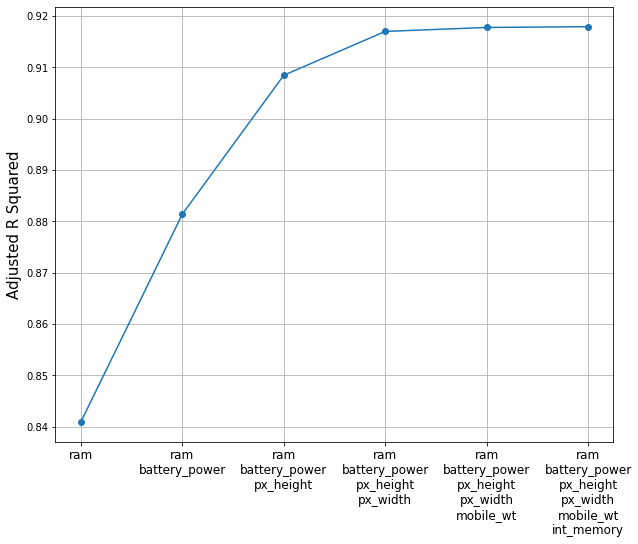

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))

plt.xticks(steps,['\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared',fontsize=15)
plt.grid(True)
plt.show()

#ram, battery_power, px_width, px_height 가 top 4 features라고 볼 수 있다.

In [ ]:
# Lasso Regression feature selection
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

feature = data.drop(columns='price_range')
target = data['price_range']
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size = 0.2, random_state = 30)
lasso = Lasso(alpha= 10).fit(X_train, Y_train)

feature_list = lasso.feature_names_in_[lasso.coef_ != 0]

print(feature_list)

#ram, battery_power, px_width, px_height 가 top 4 features라고 볼 수 있다.

['battery_power' 'px_height' 'px_width' 'ram']


In [ ]:
#PCA
from sklearn.decomposition import PCA

x = data.drop(columns='price_range')
y = data['price_range']

pca = PCA(n_components=4)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2' , 'principal component3' , 'principal component4'])

principalDf.head()

,principal component1,principal component2,principal component3,principal component4
0,430.597094,-795.788231,-390.070331,55.636140
1,504.984735,696.622368,-235.629081,343.925977
2,473.329828,763.942136,-680.059466,-113.916880
3,639.822324,779.691180,-630.783647,-30.402246
4,-718.985184,382.304525,591.040362,-392.357235


In [ ]:
pca.explained_variance_ratio_

array([0.67043941, 0.16517913, 0.1100616 , 0.05334496])

In [ ]:
sum(pca.explained_variance_ratio_)

0.999025096331274

 LogisticRegression모델

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
#Correlation / Forward feature selection / Lasso Regression 의 top4 features로 만든 LogisticRegression모델
# top4 features: 'ram', 'battery_power', 'px_height', 'px_width'
features = data[['ram', 'battery_power', 'px_height', 'px_width' ]]
target = data['price_range']
train_features, test_features, train_labels, test_labels = train_test_split(features, target, random_state= 30)

model_top4 = LogisticRegression()
model_top4.fit(train_features, train_labels)

In [ ]:
#trainset
print("trainset: ")
print(model_top4.score(train_features, train_labels))

#testsets
print("testset: ")
print(model_top4.score(test_features, test_labels))

trainset: 
0.9566666666666667
testset: 
0.972


In [ ]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

In [ ]:
#Correlation / Forward feature selection / Lasso Regression 의 top4 features로 만든 LogisticRegression모델 시각화
train_df = data[['ram', 'battery_power', 'px_height', 'px_width']]
tsne_np = TSNE(n_components = 2).fit_transform(train_df)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

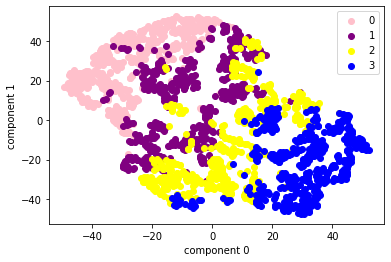

In [ ]:
import matplotlib.pyplot as plt

tsne_df['target'] = data['price_range']

tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = '0')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = '1')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = '2')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'blue', label = '3')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [ ]:
#Chi-square test로 만든 LogisticRegression모델
features = data[['battery_power', 'int_memory', 'ram', 'sc_w']]
target = data['price_range']
train_features, test_features, train_labels, test_labels = train_test_split(features, target, random_state= 30)

model_chi2 = LogisticRegression()
model_chi2.fit(train_features, train_labels)

In [ ]:
#trainset
print("trainset: ")
print(model_chi2.score(train_features, train_labels))

#testsets
print("testset: ")
print(model_chi2.score(test_features, test_labels))

trainset: 
0.516
testset: 
0.534


In [ ]:
#Chi-square test의 top4 features로 만든 LogisticRegression모델 시각화
train_df = data[['ram', 'battery_power','sc_w' ]]
tsne_np = TSNE(n_components = 2).fit_transform(train_df)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


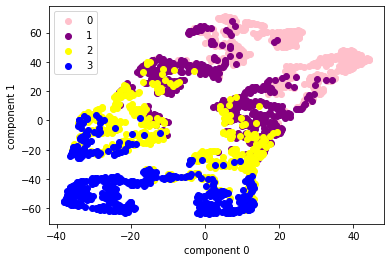

In [ ]:
import matplotlib.pyplot as plt

tsne_df['target'] = data['price_range']

tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = '0')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = '1')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = '2')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'blue', label = '3')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [ ]:
#PCA의 top4 features로 만든 LogisticRegression모델

features = principalDf
target = data['price_range']
train_features, test_features, train_labels, test_labels = train_test_split(features, target, random_state= 30)

model_pca = LogisticRegression()
model_pca.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
#trainset
print("trainset: ")
print(model_pca.score(train_features, train_labels))

#testsets
print("testset: ")
print(model_pca.score(test_features, test_labels))

trainset: 
0.9593333333333334
testset: 
0.97


In [ ]:
#PCA의 top4 features로 만든 LogisticRegression모델 시각화

train_df = principalDf
tsne_np = TSNE(n_components = 2).fit_transform(train_df)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


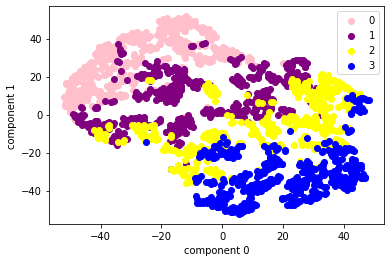

In [ ]:
tsne_df['target'] = data['price_range']

tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = '0')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = '1')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = '2')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'blue', label = '3')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [ ]:
#전체 features로 만든 LogisticRegression모델
features = data.drop(columns='price_range')
target = data['price_range']
train_features, test_features, train_labels, test_labels = train_test_split(features, target, random_state= 30)

model_all = LogisticRegression()
model_all.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
#trainset
print("trainset: ")
print(model_all.score(train_features, train_labels))

#testsets
print("testset: ")
print(model_all.score(test_features, test_labels))

trainset: 
0.6373333333333333
testset: 
0.666


In [ ]:
#전체 features로 만든 LogisticRegression모델 시각화
train_df = data.drop(columns='price_range')
tsne_np = TSNE(n_components = 2).fit_transform(train_df)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


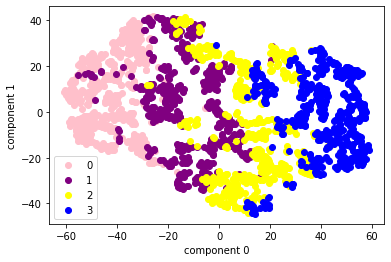

In [ ]:
tsne_df['target'] = data['price_range']

tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = '0')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = '1')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = '2')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'blue', label = '3')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()